In [185]:
import os
import random
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import SCORERS, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, HashingVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import MultinomialNB, GaussianNB
#from sklearn.linear_model import SGDlassifier(loss = ...) # loss='hinge'/'log'

from sklearn.model_selection import GridSearchCV

from joblib import dump, load

# Summary

### Bag od words with SVMs, Log-Regression, Random-Forest etc. on top 

* Build and test a preprocessing pipe:
    * Handle *LaTeX* formulas before count-vectorizatation and TFIDF transformation.
    * Test a handful of preprocessing parameters (inc. 2-grams, idf switched on/off, maximal document frequency) with a single untuned classifier.
* Test a handful of shallow multiclass classifiers with *macro-F1* as the objective, this time without broadly changing the preprocessing parameters:
* The grid-search in both step is (likely) performed on a fraction of the train data.
* Fit the tuned classifiers to the whole of train data.
* Collect the *macro-f1* scores obtained on the test data.
* ... Save the best fitted model to file

---

## Choose the volume
The whole forthcoming analysis in the notebook is parametrized by the number of records that we wish to use. The maximum that we have is 838_804 in *data/bare_all.csv*, but we will choose to work with a smaller sample for convenience. This is done conceptually before any considerations about testing, validating etc., as if we simply had harvested a smaller dataset. Also, we will first tune the classifiers on a *small_number* of records, and only later refit and evaluate them on a *big_number* of records as if we had harvested additional data after the tuning (see below). 

In [274]:
small_number = 50_000
big_number = 55_000 # 838_804

## Define the measure of success

In [187]:
# available scikit-learn's scorers
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [188]:
# my choice
scoring = "f1_macro"
average = "macro"

---

## Read in the two-column data frame (text + labels)

In [189]:
file = os.path.join("data", "bare_all.csv")
data = pd.read_csv(file, delimiter='\t', nrows=small_number)

# it happens to be shuffled already
data_train = data[: int(small_num*0.8)]
data_test = data[int(small_num*0.8) :]

text_train = data_train.text
label_train = data_train.label

## Have a look at the data

In [190]:
print(f"No. all records in memory: {len(data)}")
with pd.option_context('display.max_colwidth', 120):
    display(data_train[:3])

No. all records in memory: 50000


,text,label
0,On the interplay between star formation and feedback in galaxy formation simulations. We investigate the star forma...,phys
1,Transversal Homotopy Monoids of Complex Projective Space. We will give a geometric description of the nth transvers...,math
2,Remarks on some typical assumptions in dynamo theory. Some concepts used in the theory of convection-driven dynamos...,phys


Abstracts of scientific papers tend to be written in a formal style, to not contain typos, nor direct citations, little references, ...

In [191]:
for _ in range(2):
    print(text_train.iloc[random.choice(range(len(text)))])
    print("---")

Bounds on generators and relations for the algebra of $SL_2(\C)$ conformal blocks.  We show that the Cox ring of the moduli of $SL_2(\C)$ quasi-parabolic principal bundles on a marked curve is generated by conformal blocks of level 1 and 2. We show that the ideal which vanishes on these generators is generated by forms of degrees $2, 3, 4.$ 
---
T/Key: Second-Factor Authentication From Secure Hash Chains.  Time-based one-time password (TOTP) systems in use today require storing secrets on both the client and the server. As a result, an attack on the server can expose all second factors for all users in the system. We present T/Key, a time-based one-time password system that requires no secrets on the server. Our work modernizes the classic S/Key system and addresses the challenges in making such a system secure and practical. At the heart of our construction is a new lower bound analyzing the hardness of inverting hash chains composed of independent random functions, which formalizes t

### One messy but informative kind of writing they have are LaTeX formulas (*\$...\$*)

In [192]:
text_train[6][:400]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von '

### We choose to either mask them with * \_latex\_ * or flag them by appending * \_latex\_ * in front of each such expression. 

In [193]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

    # self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
    # why does it differ from  r'(\$.+?\$)' ?
    
class DeLaTeX(BaseEstimator, TransformerMixin):
    
    def __init__(self, behave=None, pattern=r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})", repl = ' _LATEX_ '):
        self.repl = ' _LATEX_ '
        self.pattern = pattern
        self.behave = behave
        
        if self.behave == 'mask':
            self.repl = ' _LATEX_ '
        elif self.behave == 'flag':
            self.repl = r' _LATEX_ \1'
        return None

    def fit(self, X, y=None):
        if not isinstance(X, pd.core.series.Series):
            raise TypeError("The data must be a pandas Series of strings")
        return self

    def transform(self, X):
        if self.behave:
            return X.str.replace(self.pattern, self.repl)
        return X
            

In [194]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(DeLaTeX)

In [195]:
delatex = DeLaTeX(behave = None)
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von Neumann algebra of $\\Gamma$. Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

In [196]:
delatex = DeLaTeX(behave = 'mask')
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_  on a single element  _LATEX_  of a given Hilbert space  _LATEX_ . As  _LATEX_  might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ -space associated to the group von Neumann algebra of  _LATEX_ . Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

In [197]:
delatex = DeLaTeX(behave = 'flag')
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_ $\\Gamma$ on a single element  _LATEX_ $\\psi$ of a given Hilbert space  _LATEX_ $\\mathcal{H}$. As  _LATEX_ $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ $L^1$-space associated to the group von Neumann algebra of  _LATEX_ $\\Gamma$. Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

## Encode the labels

In [198]:
# 'cs' -> 0, ..., 'stat' -> 5

label_e = LabelEncoder()
y_train = label_e.fit_transform(label_train)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat']


## Have a look at the most frequent words. Choose winners as the stop-words.
Take note of the rank of our '\_latex\_'

In [199]:
delatex = DeLaTeX(behave = 'flag')
count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(delatex.fit_transform(text_train))
word_counts_train.shape

(40000, 76209)

In [200]:
sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(round(sum_word_counts_train[0, i],-3), word) for word, i in count_v.vocabulary_.items()],reverse=True)[:10]

[(423000, 'the'),
 (268000, 'of'),
 (148000, 'and'),
 (132000, 'in'),
 (110000, 'to'),
 (85000, 'we'),
 (78000, 'is'),
 (73000, 'for'),
 (71000, '_latex_'),
 (57000, 'that')]

In [201]:
stopwords = ['the', 'of', 'and', 'in','to','we','is'] # 'for' seems already mathematical/computer-sciency

---

## Go step by step through an arbitrary pipeline 

In [202]:
text_train.shape

(40000,)

In [203]:
delatex = DeLaTeX(behave='mask')
notex_text_train = delatex.fit_transform(text_train)

In [204]:
tfidf_v = TfidfVectorizer(use_idf=True, stop_words=stopwords, min_df = 2, max_df=0.8, strip_accents='unicode')
tfidf_scores_train = tfidf_v.fit_transform(notex_text_train)

In [205]:
lsvc = LinearSVC(C=1, class_weight='balanced')
lsvc.fit(tfidf_scores_train, y_train)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Ok, let's just have some fun first:

In [207]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms. This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
novel intuitive proof of $\limit_{x\to 0} x = 0$ convergence fomula,
""",
"""
inflation resources market stock bonds derivatives
""",
"""
confidence Bayesian p value marginalization Monte Carlo
"""
])

label_e.inverse_transform(lsvc.predict(tfidf_v.transform(delatex.transform(random_abstracts ))))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

Looks promising :)
Here's the actual score on a test set:

In [209]:
text_test = data_test.text
label_test = data_test.label
y_test = label_e.transform(label_test)

predicted_y_test = lsvc.predict(tfidf_v.transform(delatex.transform(text_test)))

print("Macro F1:", f1_score(y_test, predicted_y_test, average="macro"))
print(classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
nofuss_conf_mtrx = confusion_matrix(y_test, predicted_y_test)
print(nofuss_conf_mtrx)

Macro F1: 0.7645413819228147
              precision    recall  f1-score   support

          cs       0.84      0.88      0.86      1378
        math       0.88      0.90      0.89      2340
        phys       0.97      0.95      0.96      5933
       q-bio       0.63      0.57      0.60       139
       q-fin       0.79      0.69      0.74        45
        stat       0.52      0.55      0.54       165

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.92      0.92      0.92     10000

[[1215   89   33   10    1   30]
 [  93 2114   89    4    1   39]
 [  73  170 5654   24    5    7]
 [  15   10   28   79    0    7]
 [   4    6    2    1   31    1]
 [  42   16    8    7    1   91]]


"By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$." https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Let's store the above easily obtained confusion matrix in a *nofuss_conf_mtrx* variable.

Having trained on a fraction of all records with an untuned Linear SVM, we have reached ~0.76 macro-F1 (out of sample) pulled down by poor performomance on classification wrt rarer classes. E.g. many *cs* and *math* are confused with *stat* (and vice versa), and similarly for *q-bio* and *physics*. This is actually sensible.

---

## Grid searching by hand through preprocessing params with Linear SVM Classifiers
The goal now is to put a finger on reasonable preprocessing parameters. It would of course be better to include them in one global grid search with each classifier, but we do not have the resources for that. We are simply hoping to gain insight into whether any of the parameters (strategies) in the grid below is particularly important.

In [210]:
pipe = []
pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
pipe.append(( 'tfidf_v', TfidfVectorizer(analyzer = 'word', strip_accents='unicode', min_df = 2)  ))
pipe.append(( 'LinearSVC', LinearSVC(C=1, penalty='l2', class_weight='balanced')  ))

In [211]:
params = {
    'delatex__behave': ['mask', 'flag', None],
    'tfidf_v__stop_words': [stopwords, None],
#    'tfidf_v__ngram_range': [(1, 1), (1,2)], # cannot afford it computationally
    'tfidf_v__use_idf': [True, False],
    'tfidf_v__max_df': [0.6, 0.8, 1.0],
}

In [212]:
print(text_train.shape)
print(y_train.shape)

(40000,)
(40000,)


In [170]:
# LONG WAIT

# there's some bug with njobs different than 1 because of the delatex in the pipe
# may be related to the fact that check_estimator(DeLaTeX) raises an error due to DeLaTeX using the pandas' vectorized str method 

grid_s = GridSearchCV(Pipeline(pipe), params, cv=4, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False, verbose=1)
grid_s.fit(text_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 32.9min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'delatex__behave': ['mask', 'flag', None], 'tfidf_v__stop_words': [['the', 'of', 'and', 'in', 'to', 'we', 'is'], None], 'tfidf_v__use_idf': [True, False], 'tfidf_v__max_df': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=1)

In [171]:
grid_s.best_score_

0.7648662306066194

In [172]:
grid_s.best_params_

{'delatex__behave': None,
 'tfidf_v__max_df': 0.8,
 'tfidf_v__stop_words': None,
 'tfidf_v__use_idf': True}

In [173]:
grid_cv_results = pd.DataFrame(grid_s.cv_results_)
cols = ['param_' + param for param in params.keys()] + ['mean_test_score']
results_df = grid_cv_results[cols].sort_values(by=['mean_test_score'], ascending=False)

In [174]:
results_df

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__use_idf,param_tfidf_v__max_df,mean_test_score
30,None,None,True,0.8,0.764866
10,mask,None,True,1,0.764103
22,flag,None,True,1,0.764103
34,None,None,True,1,0.764037
32,None,"[the, of, and, in, to, we, is]",True,1,0.763979
28,None,"[the, of, and, in, to, we, is]",True,0.8,0.763979
26,None,None,True,0.6,0.762639
24,None,"[the, of, and, in, to, we, is]",True,0.6,0.762639
18,flag,None,True,0.8,0.762607
6,mask,None,True,0.8,0.762607


So, with regards to our preprocessing steps, as a first order conclusion:
    * All the parameters seem rather unimportant.
    * The most important ones - in the sense of crowding the top of the above list - seem to be: using idf over not using it, and larger max_df rather than smaller.
    * Our DeLaTeX behavior and stopwords do not have a significant effect.
   
In light of the above we will stick to:
    * masking LaTeX
    * no stop-words
    * using IDFs
    * no max_df limit (meaning the default =1.0)

---

### For convenience, I will mask the LaTeX in the whole dataset once, save it to file. From now on I will use it as the default dataset to work on.
Imagining than I will be given a new arXiv metadata to classify, I would have to first explicitly push it through the DeLaTeX transformer.

In [176]:
# read in all the records we have on disk
file = os.path.join("data", "bare_all.csv")
all_data = pd.read_csv(file, delimiter='\t', nrows=None)

# mask away the LaTeX
notex_data = pd.DataFrame()
delatex = DeLaTeX(behave='mask')
notex_data['text'] = delatex.transform(all_data.text)
notex_data['label'] = all_data.label

# and store it to disk
file = os.path.join("data", "notex_all.csv")
notex_data.to_csv(file, sep = '\t', index = False)

# clear the pythonic variables from memory
%reset_selective -f "^all_data$"
%reset_selective -f "^notex_data$"

In [213]:
# read back in the smaller sample for convenience
small_num

50000

In [214]:
file = os.path.join("data", "notex_all.csv")
data = pd.read_csv(file, delimiter='\t', nrows=small_num)

data_train = data[: int(small_num*0.8)]
data_test = data[int(small_num*0.8) :]

text_train = data_train.text
label_train = data_train.label

In [215]:
text_train[6][:400]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_  on a single element  _LATEX_  of a given Hilbert space  _LATEX_ . As  _LATEX_  might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ -space associated to the group'

---

## Automated GridSearchCV for multiple classifiers

In [216]:
text_train.shape

(40000,)

### Specify models with a grid of hyper-parameters to choose from

In [234]:
models = {
    
    'LogReg': [LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='multinomial', max_iter=500),
                  [( 'C', [0.2, 1, 5, 10, 25] ), ('multi_class', ['multinomial','ovr'])]
                 ],
    'RndFClf': [RandomForestClassifier(class_weight='balanced', n_estimators=200, criterion="gini"),
                 [('max_depth', [10, 15, 20, 25]) , ('min_samples_leaf', [1E-5, 1E-4, 1E-3])]
                ],
    'LinSVC': [LinearSVC(class_weight='balanced'),
                  [( 'C', [0.008, 0.04, 0.01, 0.2, 0.05, 1, 5] )]
                 ],
    'NearCen': [NearestCentroid(),
                [('metric', ['euclidean','manhattan'])]
               ],
    'MultNB': [MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None),
                [('alpha', [0.001, 0.003, 0.01, 0.03, 0.1])]
               ]
}

### Helper functions

In [235]:
def build_clf(name, model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
    pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=True, strip_accents='unicode', min_df = 2)  ))
    pipe.append(( name, model  ))
    
    return Pipeline(pipe)

In [236]:
def build_pipe_params(name, model_params):
    
    params = {}
    for (param_name, range_) in model_params:
        params[name + '__' + param_name] = range_
        
    return params

### Grid Search with cv=4 (stratified by default)
Hyper-parameter tuning: Measure the score for each combination of values. Use cross-validation to reduce overfitting.

In [281]:
# GRID-SEARCH

# collect the best_params for the models
grid_s_results = {}

for name, (model, model_params) in models.items():
    
    print(name)
    pipe = build_clf(name, model)
    params = build_pipe_params(name, model_params)
    
    grid_s = GridSearchCV(pipe, params, cv=4, scoring=scoring,\
                          iid=False, return_train_score=True,\
                          n_jobs=3, refit=False, verbose=1)
    grid_s.fit(text_train, y_train)
    
    print(grid_s.best_score_, "\n")
    grid_s_results[name] = grid_s


ValueError: too many values to unpack (expected 2)

In [248]:
# examine the obtaind scores and best_params
for name, grid_s in grid_s_results.items():
    print(f"{name:>8}, {grid_s.best_score_}, {grid_s.best_params_}")

  LogReg, 0.7662735115316531, {'LogReg__C': 5, 'LogReg__multi_class': 'ovr'}
 RndFClf, 0.6971225628503566, {'RndFClf__criterion': 'gini', 'RndFClf__max_depth': 25, 'RndFClf__min_samples_leaf': 0.0001}
  LinSVC, 0.7657854576331379, {'LinSVC__C': 0.2}
 NearCen, 0.6603548185074385, {'NearCen__metric': 'euclidean'}
  MultNB, 0.7443547450863567, {'MultNB__alpha': 0.01}


### Append the best_params and f1-scores from grid-search to the *models* dict and store it in a file

In [249]:
for name, grid_s in grid_s_results.items():
    
    models[name].append(grid_s.best_score_)
    models[name].append(grid_s.best_params_)

In [250]:
# joblib / pickle
dump(models, f'arXiv_shallow_tuning_on_{small_number}.joblib') 

['arXiv_shallow_tuning_results.joblib']

## Display macro F1 for all the classfiers

In [256]:
models = load('arXiv_shallow_tuning_results.joblib')

# The grid_search did not do a final 'refit'
# We do it by hand and store the scores obtained on the test data in a new dict
# along with the refitted models

small_test_ranking = {}

print(f"Fitting to {len(text_train)} records. Testing on unseen {len(text_test)}.")

for name, (model, original_grid, score, best_params_) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**best_params_)
    tick = time.time()
    clf.fit(text_train, y_train)
    tock = time.time()
    
    small_test_ranking[name] = [f1_score(y_test, clf.predict(text_test), average='macro'), clf]
    
    print(f"Fitted {name}")

Fitting to 40000 records. Testing on unseen 10000.
Fitted LogReg
Fitted RndFClf
Fitted LinSVC
Fitted NearCen
Fitted MultNB


In [260]:
# Sort the dict with final F1 scores

scores_list = sorted(small_test_ranking.items(), key=lambda model: model[1][0], reverse = True)
scores_sorted = {name: score for (name, [score, _] ) in scores_list}
scores_sorted

{'LinSVC': 0.7761207948470307,
 'LogReg': 0.7705683999116041,
 'MultNB': 0.7510970904737243,
 'RndFClf': 0.7134458431327917,
 'NearCen': 0.6564957532555155}

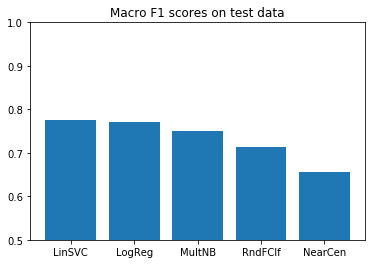

In [262]:
count = range(len(scores_sorted))
plt.ylim(0.5, 1)
plt.bar(count, list(scores_sorted.values()))
plt.xticks(count, list(scores_sorted.keys()))
plt.title(f"Macro F1 scores on test data")
plt.show()

---

## Fit more train data to the tuned classifiers.
The classifiers were tuned on a small number of records. Now we fit them anew to a bigger chunk of data.
It would of course be more desirable to do the grid-search on the bigger chunk to begin with. We are just imagining a scenario, where we've obtained more data after tuning, and we wish to refit the model without repeating the grid-search. On should bare in mind that in general the tuned parameters are functions of the volume of data, so this approach relies on the assumption that those functions are not varying very fast, and it probably makes sense only if the new chunk is not many orders of magnitude bigger.

In [275]:
models = load('arXiv_shallow_tuning_results.joblib')

file = os.path.join("data", "notex_all.csv")
big_data = pd.read_csv(file, delimiter='\t', nrows=large_number)  # lol, "big-data" 

In [286]:
big_data_train = big_data[:int(0.8*large_number)]
big_data_test = big_data[int(0.8*large_number):]

big_text_train = big_data_train.text
big_y_train = label_e.transform(big_data_train.label)

big_text_test = big_data_test.text
big_y_test = label_e.transform(big_data_test.label)

In [298]:
# the scores obtained on the test sample are stored in a new dict and the refitted models are appended in the 'models' dict

big_test_ranking = {}

print("Fitting on big-data :)")

for name, (model, original_grid, score, best_params_) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**best_params_)
    tick = time.time()
    clf.fit(big_text_train, big_y_train)
    tock = time.time()
    
    big_test_ranking[name] = [f1_score(big_y_test, clf.predict(big_text_test), average='macro'), clf]
    
    print(f" {name} in {(tock - tick)/60:.0f} min.")

Fitted LogReg in 2 min. on big-data.
Fitted RndFClf in 2 min. on big-data.
Fitted LinSVC in 0 min. on big-data.
Fitted NearCen in 0 min. on big-data.
Fitted MultNB in 0 min. on big-data.


### Display macro F1 for all the classfiers - after refitting on bigger dataset.

In [308]:
# Sort the dict with final F1 scores
# Save the the winning classifier

ranking_list = sorted(big_test_ranking.items(), key=lambda item: item[1][0], reverse = True)

winner = ranking_list[0][0]
winner_clf = big_test_ranking[winner][1]

scores_sorted = {name: score for (name, [score, _]) in ranking_list}
scores_sorted

{'LogReg': 0.7888135808707667,
 'LinSVC': 0.7834846803690315,
 'MultNB': 0.7641103960001768,
 'RndFClf': 0.6731152958808639,
 'NearCen': 0.6384163392173875}

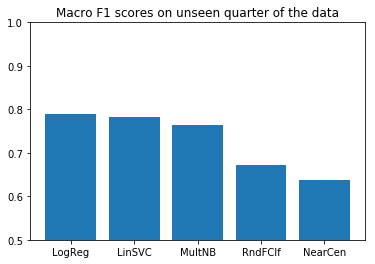

In [301]:
count = range(len(scores_sorted))
plt.ylim(0.5, 1)
plt.bar(count, list(scores_sorted.values()))
plt.xticks(count, list(scores_sorted.keys()))
plt.title("Macro F1 scores on unseen quarter of the data")
plt.show()

In [309]:
predicted_big_y_test = winner_clf.predict(big_text_test)

In [310]:
print(classification_report(big_y_test, predicted_big_y_test, target_names=label_e.classes_))
conf_mtrx = confusion_matrix(big_y_test, predicted_big_y_test)
conf_mtrx

              precision    recall  f1-score   support

          cs       0.84      0.89      0.86      5236
        math       0.89      0.91      0.90      9161
        phys       0.98      0.95      0.97     24190
       q-bio       0.60      0.77      0.67       462
       q-fin       0.70      0.80      0.75       246
        stat       0.55      0.62      0.58       705

   micro avg       0.93      0.93      0.93     40000
   macro avg       0.76      0.82      0.79     40000
weighted avg       0.93      0.93      0.93     40000



array([[ 4639,   314,    85,    51,    17,   130],
       [  395,  8294,   245,    35,    38,   154],
       [  288,   595, 23100,   135,    19,    53],
       [   44,    12,    32,   355,     0,    19],
       [   19,    15,     5,     1,   198,     8],
       [  165,    62,    12,    17,    10,   439]], dtype=int64)

### The *Statistics* class appears to be escpecially ambigous 

### See how the articles have flown between classes in the confusion matrix

In [304]:
rescaled_nofuss_conf_mtrx = nofuss_conf_mtrx * len(big_y_test)/len(y_test)
(conf_mtrx - rescaled_nofuss_conf_mtrx).sum() # 0

0.0

In [305]:
np.round(conf_mtrx - rescaled_nofuss_conf_mtrx, -1)

array([[-220.,  -40.,  -50.,   10.,   10.,   10.],
       [  20., -160., -110.,   20.,   30.,   -0.],
       [  -0.,  -80.,  480.,   40.,   -0.,   20.],
       [ -20.,  -30.,  -80.,   40.,    0.,  -10.],
       [   0.,  -10.,   -0.,   -0.,   70.,    0.],
       [  -0.,   -0.,  -20.,  -10.,   10.,   80.]])

### *physics*, *q-bio*, *q-fin*, and *stat* classes got inflated, wheras *cs* and *math* depleted. Curious.

---

## Store the best model in a file

In [311]:
winner_clf

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [313]:
# joblib / pickle
dump(winner_clf, winner+f'_fit-to-{big_number}.joblib') 

['LogReg_fit-to-55000.joblib']

In [316]:
some_clf = load(winner+f'_fit-to-{big_number}.joblib')
some_clf

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...enalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [317]:
label_e.inverse_transform(some_clf.predict(random_abstracts))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

---
### End